In [32]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout,
                                     Reshape, Bidirectional, LSTM, Dense, Lambda,
                                     Activation, BatchNormalization, TimeDistributed, Permute)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold



In [33]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')

print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())


train.dropna(axis=0, inplace=True)
train.reset_index(inplace = True, drop=True)

Number of NaNs in train set      :  565


In [34]:

unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)
train = train[train['IDENTITY'] != 'UNREADABLE']

train['IDENTITY'] = train['IDENTITY'].str.upper()
train.reset_index(inplace = True, drop=True)

print(train)

                FILENAME       IDENTITY
0        TRAIN_00001.jpg      BALTHAZAR
1        TRAIN_00002.jpg          SIMON
2        TRAIN_00003.jpg          BENES
3        TRAIN_00004.jpg        LA LOVE
4        TRAIN_00005.jpg         DAPHNE
...                  ...            ...
330289  TRAIN_330957.jpg          LENNY
330290  TRAIN_330958.jpg        TIFFANY
330291  TRAIN_330959.jpg  COUTINHO DESA
330292  TRAIN_330960.jpg         MOURAD
330293  TRAIN_330961.jpg        HELOISE

[330294 rows x 2 columns]


In [35]:

def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # boş beyaz resim
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [37]:
train_size = 30000

In [38]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [41]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)


In [42]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-' '" # eğitim setimde küçük harfler olmadığından kullanmadım
max_str_len = 24 # maximum uzunluk (daha kısa sözcükler -1 ile padding yapılacaktır)
num_of_characters = len(alphabets) + 1 # +1 boşluk karakteri için (boşkuğu alfabeme ekledim ancak hata aldım +1 olmadan)
num_of_timestamps = 64 # tahmin edilecek etikelerin ve zaman adımının max değeri

#etiketleri numaralara çevirmek için
def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)
    
#tahmin edilen değerleri sözcüklere çevirmek için
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # padding ile verdiğimiz -1 olunca döngü duracak
            break
        else:
            ret+=alphabets[ch]
    return ret

In [43]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY']) 

In [44]:
input_data = Input(shape=(256, 64, 1), name='input')

In [45]:
from tensorflow.keras.layers import AveragePooling2D

def lenet5_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(6, kernel_size=(5, 5), activation='tanh', padding='same')(inputs)
    x = AveragePooling2D(pool_size=(2, 2))(x)

    x = Conv2D(16, kernel_size=(5, 5), activation='tanh')(x)
    x = AveragePooling2D(pool_size=(2, 2))(x)

    # Reshape (batch, width, height * channels)
    conv_shape = x.shape  # (None, h, w, c)
    x = Reshape((int(conv_shape[2]), int(conv_shape[1] * conv_shape[3])))(x)

    x = TimeDistributed(Dense(120, activation='tanh'))(x)
    x = TimeDistributed(Dense(84, activation='tanh'))(x)
    x = TimeDistributed(Dense(num_classes, activation='softmax'), name='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



In [46]:
def cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Conv çıkışı (batch, H, W, C) → (batch, W, H*C) olacak şekilde reshape
    conv_shape = x.shape  # (None, height, width, channels)
    x = Reshape((int(conv_shape[2]), int(conv_shape[1] * conv_shape[3])))(x)

    # Her zaman adımı için karakter tahmini
    x = TimeDistributed(Dense(128, activation='relu'))(x)
    x = Dropout(0.3)(x)
    x = TimeDistributed(Dense(num_classes, activation='softmax'), name='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Reshape, Dense, Dropout, TimeDistributed, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Permute, TimeDistributed

def vgg_style_model(input_shape, num_classes, max_label_len):
    model = Sequential()
    
    # CNN blokları
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))  # h/2, w/2

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))  # h/4, w/4

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))  # h/8, w/8

    # CNN çıkışı: (batch, h', w', c)
    # Permute: (batch, w', h', c) → sekans boyutunu genişlik yap
    model.add(Permute((2, 1, 3)))  # (batch, width, height, channels)

    # Reshape: (batch, timesteps, features)
    # Burada width → max_label_len olacak şekilde zorla
    model.add(Reshape((max_label_len, -1)))  # (batch, max_label_len, features)

    model.add(LSTM(128, return_sequences=True))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [49]:
def crnn_model_ctc(input_shape, num_classes):
    input_data = Input(name='input', shape=input_shape, dtype='float32')
    inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

    inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
    inner = Dropout(0.3)(inner)

    inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
    inner = Dropout(0.3)(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

    ## RNN
    inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
    inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

    ## OUTPUT
    inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
    y_pred = Activation('softmax', name='softmax')(inner)

    model = Model(inputs=input_data, outputs=y_pred)
    model.summary()

    return input_data, y_pred,input_data



In [50]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [51]:
def plot_crnn_fold_history(history, fold_no):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train CTC Loss')
    plt.plot(history.history['val_loss'], label='Val CTC Loss')
    plt.title(f'CRNN Fold {fold_no} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [52]:
def plot_accuracy_fold(history, fold_no, model_name):

    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Fold {fold_no} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [53]:
def train_with_kfold_ctc(model_fn, X, y, max_str_len, num_classes, input_shape, epochs, batch_size, k, model_name="Model"):
    from sklearn.model_selection import KFold
    import numpy as np
    import tensorflow.keras.backend as K
    from keras.layers import Input, Lambda
    from keras.models import Model

    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        y_pred = y_pred[:, 2:, :]  # ilk birkaç timestep genelde bozuk olur
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    val_losses = []
    from tensorflow.keras.callbacks import EarlyStopping

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    for fold_no, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n📁 Fold {fold_no+1}/{k}")

        # Modeli oluştur
        base_model, y_pred, input_data = model_fn(input_shape, num_classes)

        # CTC inputları
        labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
        input_length = Input(name='input_length', shape=[1], dtype='int64')
        label_length = Input(name='label_length', shape=[1], dtype='int64')

        # y_pred[:, 2:, :] uygulanacağı için timestep düşüyor
        y_pred_cut = Lambda(lambda x: x[:, 2:, :], name='cut_y_pred')(y_pred)

        ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
            [y_pred, labels, input_length, label_length]
        )

        model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
        model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

        # Giriş uzunluğu (kesilmiş y_pred üzerinden alınmalı)
        timestep_len = K.int_shape(y_pred_cut)[1]
        print("timestep_len (cut):", timestep_len)

        # Giriş ve etiket uzunlukları
        train_input_len = np.ones((len(train_idx), 1), dtype='int32') * timestep_len
        train_label_len = np.minimum(np.sum(y[train_idx] != -1, axis=1, keepdims=True), timestep_len).astype('int32')

        val_input_len = np.ones((len(val_idx), 1), dtype='int32') * timestep_len
        val_label_len = np.minimum(np.sum(y[val_idx] != -1, axis=1, keepdims=True), timestep_len).astype('int32')

        print("Max train_input_len length (train):", train_input_len)
        print("Max label length (train):", np.max(train_label_len))
        print("Max label length (val):", np.max(val_label_len))

        dummy_output = np.zeros(len(train_idx))
        valid_output = np.zeros(y[val_idx].shape)

        history = model_final.fit(
            x=[X[train_idx], y[train_idx], train_input_len, train_label_len],
            y=dummy_output,
            validation_data=(
                [X[val_idx], y[val_idx], val_input_len, val_label_len],
                valid_output
            ),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[early_stop]
        )
        model_final.save(f"{fold_no+1}-{k}-{model_name}.keras")
        model_final.save(f"{fold_no+1}-{k}-{model_name}.h5")
        # Her fold için loss grafiği
        plot_crnn_fold_history(history, fold_no + 1)

        val_losses.append(min(history.history['val_loss']))

    return val_losses



In [55]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_with_kfold(model_fn, X, y, input_shape, num_classes, epochs, 
                     batch_size, k, model_name="Model",max_label_len=None):
    
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    val_accuracies = []

    for fold_no, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n📁 Fold {fold_no+1}/{k} - {model_name}")
        
        if max_label_len:
            model = model_fn(input_shape, num_classes, max_label_len)
        else:
            model = model_fn(input_shape, num_classes)
        

        # ✅ Kayıt klasörünü oluştur
        save_dir = f"models/{model_name}/fold_{fold_no+1}"
        os.makedirs(save_dir, exist_ok=True)

        # ✅ En iyi modeli val_accuracy’ye göre kaydet
        checkpoint_cb = ModelCheckpoint(
            filepath=os.path.join(save_dir, f"best_{model_name}.keras"),
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )

        # ✅ Erken durdurma
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X[train_idx], y[train_idx],
            validation_data=(X[val_idx], y[val_idx]),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[early_stop, checkpoint_cb]
        )

        # ✅ Son epoch modelini de ayrıca kaydet
        model.save(os.path.join(save_dir, f"last_{model_name}.keras"))

        plot_accuracy_fold(history, fold_no + 1, model_name)
        val_accuracies.append(max(history.history['val_accuracy']))
    
    return val_accuracies



In [56]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

def run_all_models(X, y, max_timesteps, max_str_len, num_classes, input_shape, 
                   epochs=30, batch_size=64, k=5):
    
    # 1. Maksimum timestep: model çıktısı kadar
    max_timesteps = 16

    # 2. Etiketleri kes
    y_trimmed = y[:, :max_timesteps]

    # 3. One-hot encode
    y_cnn = to_categorical(y_trimmed, num_classes=num_classes)
    #Yukarıdaki satırla CRNN modeline uygun hazırlanmış y değerleri categorical loss'a uyarlanmıştır

    y_lenet = to_categorical(y[:, :14], num_classes=num_classes)

    print("\n🔷 Training Simple CNN")
    cnn_result = train_with_kfold(
        model_fn=cnn_model,
        X=X, y=y_cnn,
        input_shape=input_shape,
        num_classes=num_classes,
        epochs=40, # Basit CNN ve LeNet için 40 yapılmıştır. VGG-50, CRNN-60
        batch_size=batch_size,
        k=k,
        model_name="CNN"
    )

    

    print("\n🔷 Training LeNet-5")
    lenet_result = train_with_kfold(
        model_fn=lenet5_model,
        X=X, y=y_lenet,
        input_shape=input_shape,
        num_classes=num_classes,
        epochs=40,
        batch_size=batch_size,
        k=k,
        model_name="LeNet-5" # metriklerin ölçülmesi ve model sonrası kayıt için
    )
  
    print("\n🔷 Training VGG-Style")
    vgg_result = train_with_kfold(
        model_fn=vgg_style_model,
        X=X, y=y_cnn,
        input_shape=input_shape,
        num_classes=num_classes,
        epochs=50,
        batch_size=batch_size,
        k=k,
        model_name="VGG-Style",
        max_label_len=16
    )



  
    print("\n🔷 Training CRNN (CTC loss)")
    #CTC den dolayı CRNN için farklı bir fonksiyon çağırılmıştır train_with_kfold_ctc
    crnn_result = train_with_kfold_ctc(
        model_fn=crnn_model_ctc,
        X=X, y=y,
        max_str_len=max_str_len,
        num_classes=num_classes,
        input_shape=input_shape,
        epochs=60,
        batch_size=batch_size,
        k=k,
        model_name="CRNN"
    )


    return {
        "CRNN_CTC_Loss": crnn_result,
        "CNN_Accuracy": cnn_result,
        "LeNet_Accuracy": lenet_result,
        "VGG_Accuracy": vgg_result
    }


(30000, 256, 64, 1)

🔷 Training Simple CNN

📁 Fold 1/5 - CNN


Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_15 (Reshape)                 │ (None, 16, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 16, 128)             │         524,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 16, 40)              │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 548,392 (2.09 MB)

 Trainable params: 548,392 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5973 - loss: 1.6237
Epoch 1: val_accuracy improved from -inf to 0.62011, saving model to models/CNN/fold_1/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.5974 - loss: 1.6230 - val_accuracy: 0.6201 - val_loss: 1.3983
Epoch 2/40
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6170 - loss: 1.4199
Epoch 2: val_accuracy improved from 0.62011 to 0.63556, saving model to models/CNN/fold_1/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6170 - loss: 1.4198 - val_accuracy: 0.6356 - val_loss: 1.3309
Epoch 3/40
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6324 - loss: 1.3570
Epoch 3: val_accuracy improved from 0.63556 to 0.64626, saving model to models/CNN/fold_1/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6324 - loss: 1.3570 - val_accuracy: 0.6463 - val_loss: 1.2913
Epoch 4/40
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

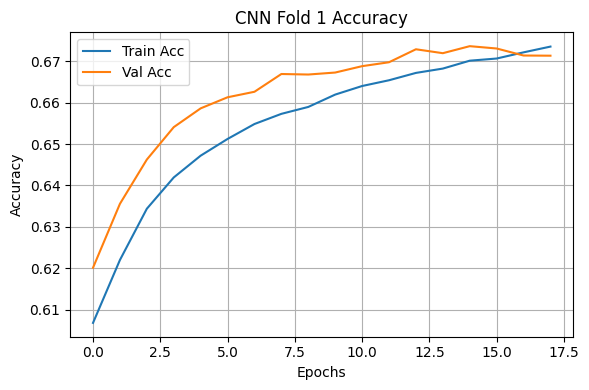


📁 Fold 2/5 - CNN


Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_16 (Reshape)                 │ (None, 16, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 16, 128)             │         524,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 16, 40)              │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 548,392 (2.09 MB)

 Trainable params: 548,392 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5974 - loss: 1.6359
Epoch 1: val_accuracy improved from -inf to 0.61654, saving model to models/CNN/fold_2/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5975 - loss: 1.6353 - val_accuracy: 0.6165 - val_loss: 1.4191
Epoch 2/40
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6156 - loss: 1.4267
Epoch 2: val_accuracy improved from 0.61654 to 0.62784, saving model to models/CNN/fold_2/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6156 - loss: 1.4267 - val_accuracy: 0.6278 - val_loss: 1.3686
Epoch 3/40
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6241 - loss: 1.3862
Epoch 3: val_accuracy improved from 0.62784 to 0.63805, saving model to models/CNN/fold_2/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6241 - loss: 1.3862 - val_accuracy: 0.6381 - val_loss: 1.3255
Epoch 4/40
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

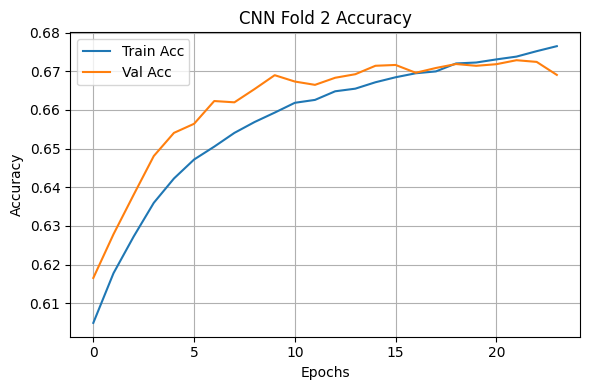


📁 Fold 3/5 - CNN


Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_17 (Reshape)                 │ (None, 16, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 16, 128)             │         524,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 16, 40)              │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 548,392 (2.09 MB)

 Trainable params: 548,392 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1490/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5964 - loss: 1.6224
Epoch 1: val_accuracy improved from -inf to 0.61373, saving model to models/CNN/fold_3/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5965 - loss: 1.6216 - val_accuracy: 0.6137 - val_loss: 1.4276
Epoch 2/40
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6144 - loss: 1.4292
Epoch 2: val_accuracy improved from 0.61373 to 0.63002, saving model to models/CNN/fold_3/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6144 - loss: 1.4291 - val_accuracy: 0.6300 - val_loss: 1.3711
Epoch 3/40
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6284 - loss: 1.3712
Epoch 3: val_accuracy improved from 0.63002 to 0.63915, saving model to models/CNN/fold_3/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6284 - loss: 1.3712 - val_accuracy: 0.6391 - val_loss: 1.3261
Epoch 4/40
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

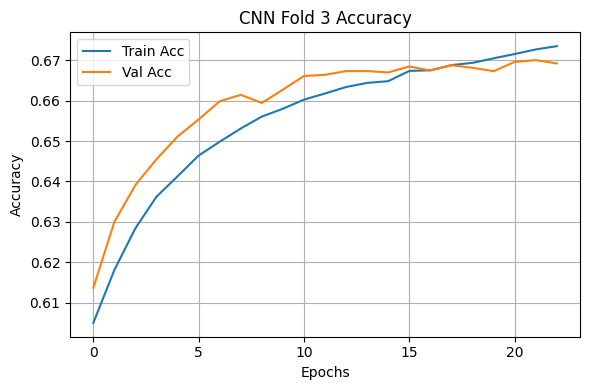


📁 Fold 4/5 - CNN


Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_18 (Reshape)                 │ (None, 16, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 16, 128)             │         524,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 16, 40)              │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 548,392 (2.09 MB)

 Trainable params: 548,392 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5987 - loss: 1.6330
Epoch 1: val_accuracy improved from -inf to 0.61677, saving model to models/CNN/fold_4/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5988 - loss: 1.6323 - val_accuracy: 0.6168 - val_loss: 1.4128
Epoch 2/40
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6146 - loss: 1.4281
Epoch 2: val_accuracy improved from 0.61677 to 0.62976, saving model to models/CNN/fold_4/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6146 - loss: 1.4280 - val_accuracy: 0.6298 - val_loss: 1.3692
Epoch 3/40
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6277 - loss: 1.3711
Epoch 3: val_accuracy improved from 0.62976 to 0.64017, saving model to models/CNN/fold_4/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6278 - loss: 1.3711 - val_accuracy: 0.6402 - val_loss: 1.3155
Epoch 4/40
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

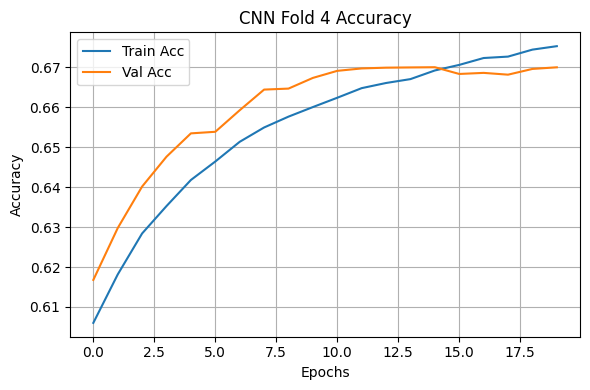


📁 Fold 5/5 - CNN


Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_19 (Reshape)                 │ (None, 16, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 16, 128)             │         524,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 16, 40)              │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 548,392 (2.09 MB)

 Trainable params: 548,392 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5975 - loss: 1.6350
Epoch 1: val_accuracy improved from -inf to 0.61804, saving model to models/CNN/fold_5/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5975 - loss: 1.6346 - val_accuracy: 0.6180 - val_loss: 1.4050
Epoch 2/40
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6149 - loss: 1.4310
Epoch 2: val_accuracy improved from 0.61804 to 0.63191, saving model to models/CNN/fold_5/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6149 - loss: 1.4310 - val_accuracy: 0.6319 - val_loss: 1.3547
Epoch 3/40
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6255 - loss: 1.3840
Epoch 3: val_accuracy improved from 0.63191 to 0.64321, saving model to models/CNN/fold_5/best_CNN.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6255 - loss: 1.3839 - val_accuracy: 0.6432 - val_loss: 1.3133
Epoch 4/40
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

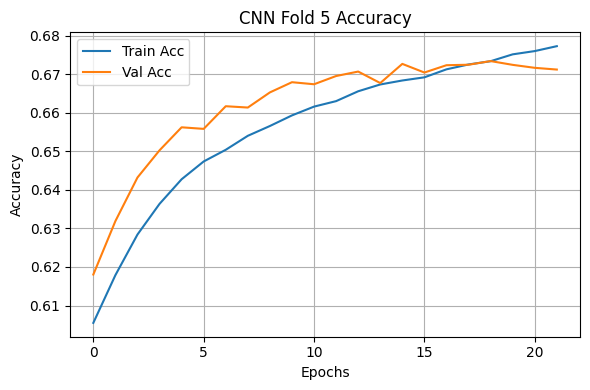


🔷 Training LeNet-5

📁 Fold 1/5 - LeNet-5


Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 256, 64, 6)          │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_10                 │ (None, 128, 32, 6)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 124, 28, 16)         │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_11                 │ (None, 62, 14, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_20 (Reshape)                 │ (None, 14, 992)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 14, 120)             │         119,160 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 14, 84)              │          10,164 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 14, 40)              │           3,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,296 (528.50 KB)

 Trainable params: 135,296 (528.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5485 - loss: 1.8285
Epoch 1: val_accuracy improved from -inf to 0.59261, saving model to models/LeNet-5/fold_1/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5486 - loss: 1.8273 - val_accuracy: 0.5926 - val_loss: 1.4701
Epoch 2/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6008 - loss: 1.4380
Epoch 2: val_accuracy improved from 0.59261 to 0.61915, saving model to models/LeNet-5/fold_1/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6008 - loss: 1.4380 - val_accuracy: 0.6192 - val_loss: 1.3677
Epoch 3/40
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6273 - loss: 1.3401
Epoch 3: val_accuracy improved from 0.61915 to 0.64032, saving model to models/LeNet-5/fold_1/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6273 - loss: 1.3400 - val_accuracy: 0.6403 - val_loss: 1.2985
Epoch 4/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 

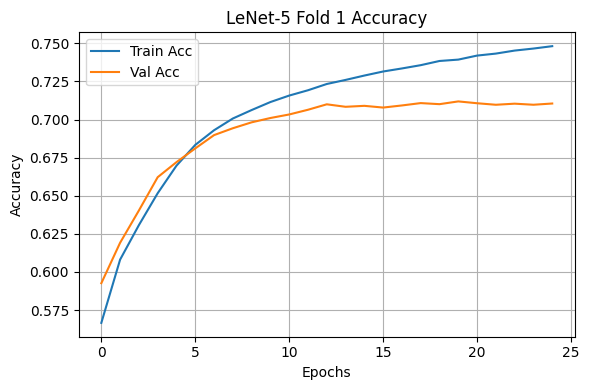


📁 Fold 2/5 - LeNet-5


Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 256, 64, 6)          │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_12                 │ (None, 128, 32, 6)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 124, 28, 16)         │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_13                 │ (None, 62, 14, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_21 (Reshape)                 │ (None, 14, 992)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 14, 120)             │         119,160 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 14, 84)              │          10,164 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 14, 40)              │           3,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,296 (528.50 KB)

 Trainable params: 135,296 (528.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5507 - loss: 1.8213
Epoch 1: val_accuracy improved from -inf to 0.59094, saving model to models/LeNet-5/fold_2/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5507 - loss: 1.8211 - val_accuracy: 0.5909 - val_loss: 1.4771
Epoch 2/40
1485/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6019 - loss: 1.4363
Epoch 2: val_accuracy improved from 0.59094 to 0.62123, saving model to models/LeNet-5/fold_2/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6020 - loss: 1.4361 - val_accuracy: 0.6212 - val_loss: 1.3662
Epoch 3/40
1490/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6292 - loss: 1.3378
Epoch 3: val_accuracy improved from 0.62123 to 0.64149, saving model to models/LeNet-5/fold_2/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6292 - loss: 1.3377 - val_accuracy: 0.6415 - val_loss: 1.3011
Epoch 4/40
1493/1500 ━━━━━━━━━━━━━━━━━━━━ 

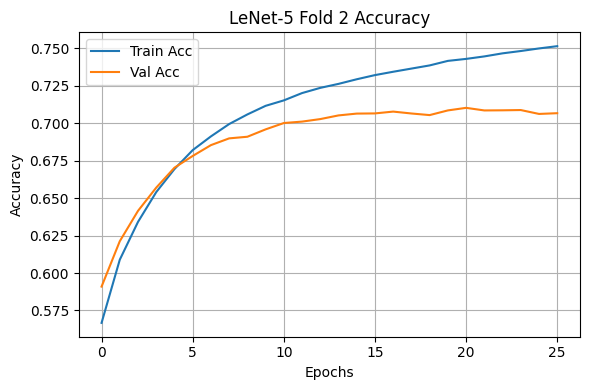


📁 Fold 3/5 - LeNet-5


Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 256, 64, 6)          │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_14                 │ (None, 128, 32, 6)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 124, 28, 16)         │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_15                 │ (None, 62, 14, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_22 (Reshape)                 │ (None, 14, 992)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 14, 120)             │         119,160 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 14, 84)              │          10,164 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 14, 40)              │           3,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,296 (528.50 KB)

 Trainable params: 135,296 (528.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5460 - loss: 1.8524
Epoch 1: val_accuracy improved from -inf to 0.58380, saving model to models/LeNet-5/fold_3/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.5461 - loss: 1.8509 - val_accuracy: 0.5838 - val_loss: 1.5067
Epoch 2/40
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6005 - loss: 1.4384
Epoch 2: val_accuracy improved from 0.58380 to 0.61574, saving model to models/LeNet-5/fold_3/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6005 - loss: 1.4384 - val_accuracy: 0.6157 - val_loss: 1.3902
Epoch 3/40
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6283 - loss: 1.3443
Epoch 3: val_accuracy improved from 0.61574 to 0.63592, saving model to models/LeNet-5/fold_3/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6283 - loss: 1.3442 - val_accuracy: 0.6359 - val_loss: 1.3266
Epoch 4/40
1493/1500 ━━━━━━━━━━━━━━━━━━━━ 

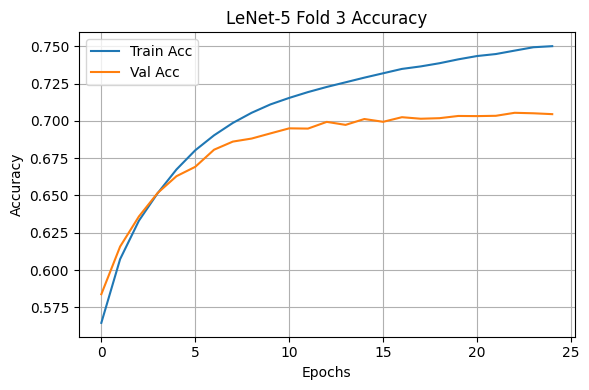


📁 Fold 4/5 - LeNet-5


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 256, 64, 6)          │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_16                 │ (None, 128, 32, 6)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 124, 28, 16)         │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_17                 │ (None, 62, 14, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_23 (Reshape)                 │ (None, 14, 992)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 14, 120)             │         119,160 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 14, 84)              │          10,164 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 14, 40)              │           3,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,296 (528.50 KB)

 Trainable params: 135,296 (528.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5501 - loss: 1.8090
Epoch 1: val_accuracy improved from -inf to 0.60077, saving model to models/LeNet-5/fold_4/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5503 - loss: 1.8074 - val_accuracy: 0.6008 - val_loss: 1.4406
Epoch 2/40
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6083 - loss: 1.4097
Epoch 2: val_accuracy improved from 0.60077 to 0.62993, saving model to models/LeNet-5/fold_4/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6083 - loss: 1.4095 - val_accuracy: 0.6299 - val_loss: 1.3419
Epoch 3/40
1485/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6381 - loss: 1.3110
Epoch 3: val_accuracy improved from 0.62993 to 0.65093, saving model to models/LeNet-5/fold_4/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6381 - loss: 1.3108 - val_accuracy: 0.6509 - val_loss: 1.2736
Epoch 4/40
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 

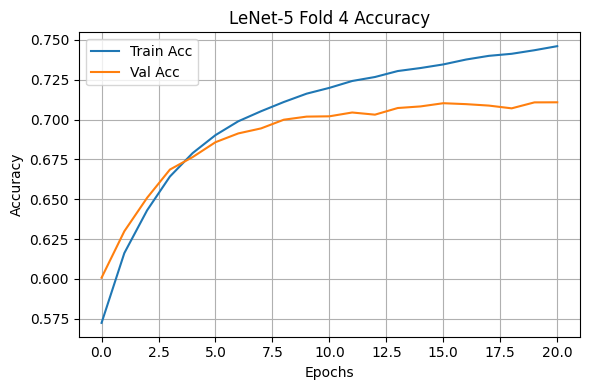


📁 Fold 5/5 - LeNet-5


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 256, 64, 6)          │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_18                 │ (None, 128, 32, 6)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 124, 28, 16)         │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_19                 │ (None, 62, 14, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_24 (Reshape)                 │ (None, 14, 992)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 14, 120)             │         119,160 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 14, 84)              │          10,164 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (TimeDistributed)            │ (None, 14, 40)              │           3,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,296 (528.50 KB)

 Trainable params: 135,296 (528.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1493/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5501 - loss: 1.8047
Epoch 1: val_accuracy improved from -inf to 0.60388, saving model to models/LeNet-5/fold_5/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5502 - loss: 1.8037 - val_accuracy: 0.6039 - val_loss: 1.4346
Epoch 2/40
1490/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6093 - loss: 1.4135
Epoch 2: val_accuracy improved from 0.60388 to 0.63435, saving model to models/LeNet-5/fold_5/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6093 - loss: 1.4133 - val_accuracy: 0.6343 - val_loss: 1.3299
Epoch 3/40
1490/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6395 - loss: 1.3102
Epoch 3: val_accuracy improved from 0.63435 to 0.65117, saving model to models/LeNet-5/fold_5/best_LeNet-5.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6395 - loss: 1.3100 - val_accuracy: 0.6512 - val_loss: 1.2752
Epoch 4/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 

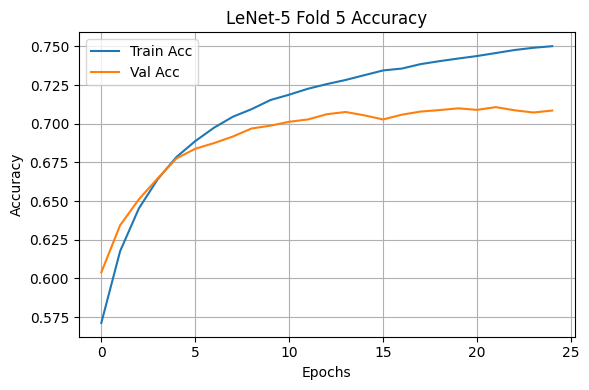


🔷 Training VGG-Style

📁 Fold 1/5 - VGG-Style


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6243 - loss: 1.3912
Epoch 1: val_accuracy improved from -inf to 0.63496, saving model to models/VGG-Style/fold_1/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.6243 - loss: 1.3910 - val_accuracy: 0.6350 - val_loss: 1.2528
Epoch 2/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6375 - loss: 1.2425
Epoch 2: val_accuracy improved from 0.63496 to 0.63922, saving model to models/VGG-Style/fold_1/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6375 - loss: 1.2425 - val_accuracy: 0.6392 - val_loss: 1.2366
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6404 - loss: 1.2309
Epoch 3: val_accuracy improved from 0.63922 to 0.64530, saving model to models/VGG-Style/fold_1/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6404 - loss: 1.2309 - val_accuracy: 0.6453 - val_loss: 1.2193
Epoch 4/50
1499/1500 ━

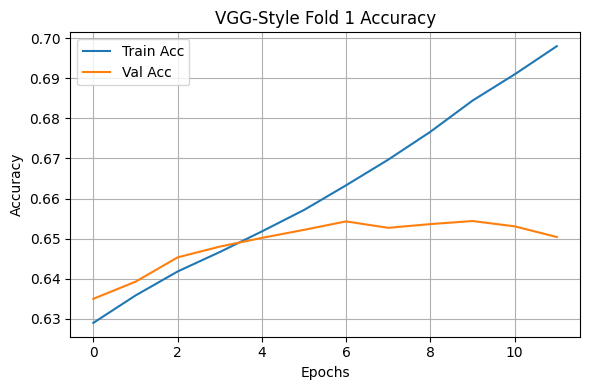


📁 Fold 2/5 - VGG-Style
Epoch 1/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6211 - loss: 1.3947
Epoch 1: val_accuracy improved from -inf to 0.63076, saving model to models/VGG-Style/fold_2/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.6212 - loss: 1.3945 - val_accuracy: 0.6308 - val_loss: 1.2642
Epoch 2/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6349 - loss: 1.2529
Epoch 2: val_accuracy improved from 0.63076 to 0.63352, saving model to models/VGG-Style/fold_2/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6349 - loss: 1.2529 - val_accuracy: 0.6335 - val_loss: 1.2484
Epoch 3/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6392 - loss: 1.2301
Epoch 3: val_accuracy improved from 0.63352 to 0.63951, saving model to models/VGG-Style/fold_2/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6392 - loss: 1.2301 - val_accuracy: 0.6395 - val_loss: 1.236

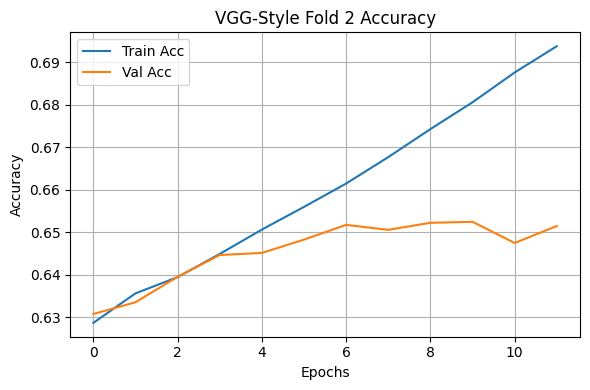


📁 Fold 3/5 - VGG-Style
Epoch 1/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6213 - loss: 1.3888
Epoch 1: val_accuracy improved from -inf to 0.63318, saving model to models/VGG-Style/fold_3/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.6214 - loss: 1.3886 - val_accuracy: 0.6332 - val_loss: 1.2640
Epoch 2/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6375 - loss: 1.2485
Epoch 2: val_accuracy improved from 0.63318 to 0.63489, saving model to models/VGG-Style/fold_3/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6375 - loss: 1.2485 - val_accuracy: 0.6349 - val_loss: 1.2481
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6413 - loss: 1.2302
Epoch 3: val_accuracy improved from 0.63489 to 0.63943, saving model to models/VGG-Style/fold_3/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6413 - loss: 1.2302 - val_accuracy: 0.6394 - val_loss: 1.237

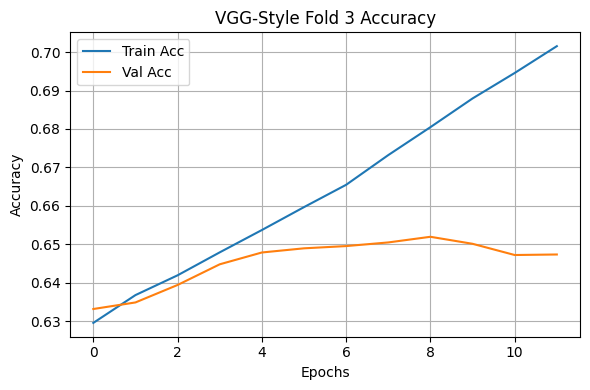


📁 Fold 4/5 - VGG-Style
Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6201 - loss: 1.4015
Epoch 1: val_accuracy improved from -inf to 0.63356, saving model to models/VGG-Style/fold_4/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.6201 - loss: 1.4014 - val_accuracy: 0.6336 - val_loss: 1.2647
Epoch 2/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6359 - loss: 1.2506
Epoch 2: val_accuracy improved from 0.63356 to 0.63704, saving model to models/VGG-Style/fold_4/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6359 - loss: 1.2506 - val_accuracy: 0.6370 - val_loss: 1.2449
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6399 - loss: 1.2323
Epoch 3: val_accuracy improved from 0.63704 to 0.64155, saving model to models/VGG-Style/fold_4/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6399 - loss: 1.2323 - val_accuracy: 0.6416 - val_loss: 1.232

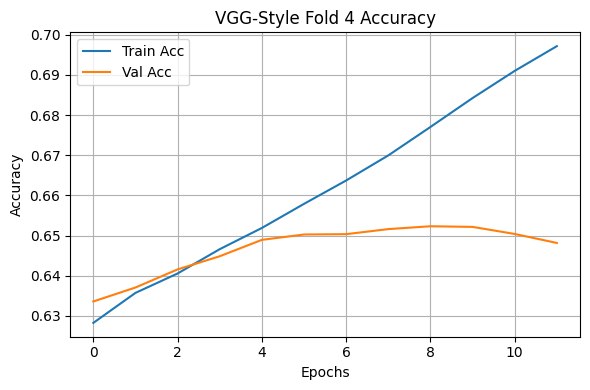


📁 Fold 5/5 - VGG-Style
Epoch 1/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6198 - loss: 1.3999
Epoch 1: val_accuracy improved from -inf to 0.63435, saving model to models/VGG-Style/fold_5/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.6198 - loss: 1.3997 - val_accuracy: 0.6344 - val_loss: 1.2648
Epoch 2/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6352 - loss: 1.2510
Epoch 2: val_accuracy improved from 0.63435 to 0.64016, saving model to models/VGG-Style/fold_5/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6352 - loss: 1.2510 - val_accuracy: 0.6402 - val_loss: 1.2357
Epoch 3/50
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6374 - loss: 1.2397
Epoch 3: val_accuracy improved from 0.64016 to 0.64280, saving model to models/VGG-Style/fold_5/best_VGG-Style.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6374 - loss: 1.2397 - val_accuracy: 0.6428 - val_loss: 1.226

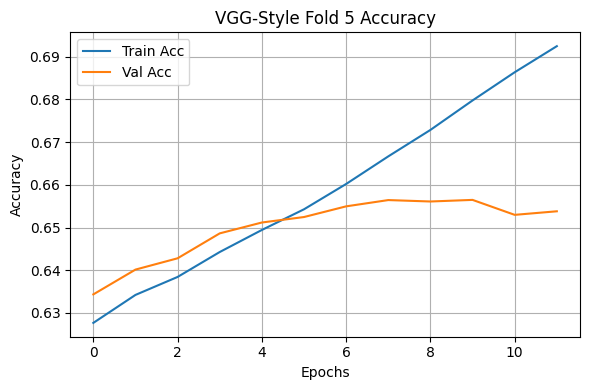


🔷 Training CRNN (CTC loss)

📁 Fold 1/5


Model: "functional_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256, 64, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256, 64, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max1 (MaxPooling2D)                  │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 32, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128, 32, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max2 (MaxPooling2D)                  │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 64, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max3 (MaxPooling2D)                  │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64, 64)              │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm1 (Bidirectional)                │ (None, 64, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (Bidirectional)                │ (None, 64, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 64, 41)              │          21,0

 Total params: 2,412,521 (9.20 MB)

 Trainable params: 2,412,073 (9.20 MB)

 Non-trainable params: 448 (1.75 KB)

timestep_len (cut): 62
Max train_input_len length (train): [[62]
 [62]
 [62]
 ...
 [62]
 [62]
 [62]]
Max label length (train): 24
Max label length (val): 21
Epoch 1/60


E0000 00:00:1750628293.621275      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_123_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 75s 44ms/step - loss: 20.7893 - val_loss: 8.2715
Epoch 2/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 4.0410 - val_loss: 2.2246
Epoch 3/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - loss: 2.5571 - val_loss: 4.7877
Epoch 4/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 2.1212 - val_loss: 1.9784
Epoch 5/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 64s 43ms/step - loss: 1.8689 - val_loss: 5.9426
Epoch 6/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 1.7183 - val_loss: 3.6149
Epoch 7/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 1.5839 - val_loss: 1.8007
Epoch 8/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 1.4566 - val_loss: 1.8427
Epoch 9/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 1.2654 - val_loss: 3.1463
Epoch 10/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 1.1894 - val_loss: 1.9914


/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

  return {key: serialize_keras_object(value) for key, value in obj.items()}


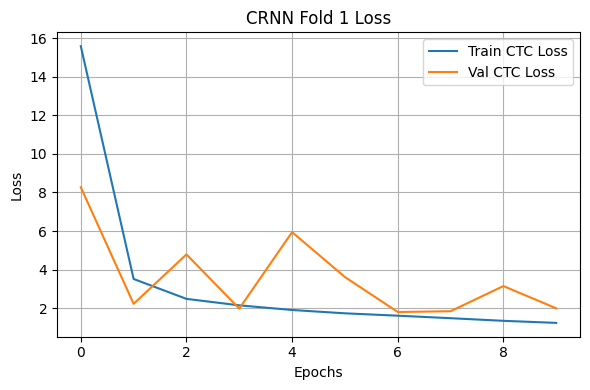


📁 Fold 2/5


Model: "functional_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256, 64, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 256, 64, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max1 (MaxPooling2D)                  │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 32, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 128, 32, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max2 (MaxPooling2D)                  │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max3 (MaxPooling2D)                  │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64, 64)              │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm1 (Bidirectional)                │ (None, 64, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (Bidirectional)                │ (None, 64, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 64, 41)              │          21,0

 Total params: 2,412,521 (9.20 MB)

 Trainable params: 2,412,073 (9.20 MB)

 Non-trainable params: 448 (1.75 KB)

timestep_len (cut): 62
Max train_input_len length (train): [[62]
 [62]
 [62]
 ...
 [62]
 [62]
 [62]]
Max label length (train): 24
Max label length (val): 22
Epoch 1/60


E0000 00:00:1750628958.359822      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_125_1/dropout_14_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 45ms/step - loss: 22.2432 - val_loss: 9.2011
Epoch 2/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 5.8553 - val_loss: 10.4526
Epoch 3/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - loss: 2.8550 - val_loss: 5.9776


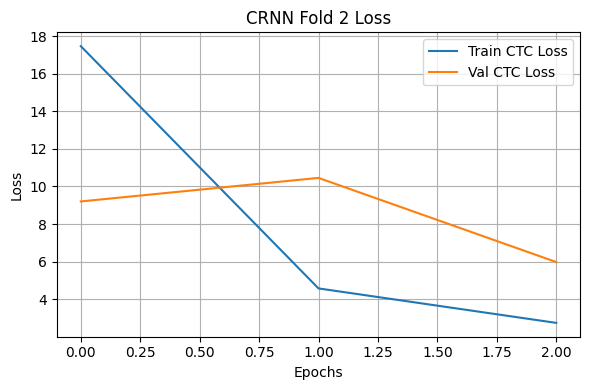


📁 Fold 3/5


Model: "functional_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256, 64, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 256, 64, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max1 (MaxPooling2D)                  │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128, 32, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 128, 32, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max2 (MaxPooling2D)                  │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 64, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max3 (MaxPooling2D)                  │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64, 64)              │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm1 (Bidirectional)                │ (None, 64, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (Bidirectional)                │ (None, 64, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 64, 41)              │          21,0

 Total params: 2,412,521 (9.20 MB)

 Trainable params: 2,412,073 (9.20 MB)

 Non-trainable params: 448 (1.75 KB)

timestep_len (cut): 62
Max train_input_len length (train): [[62]
 [62]
 [62]
 ...
 [62]
 [62]
 [62]]
Max label length (train): 24
Max label length (val): 19
Epoch 1/60


E0000 00:00:1750629170.365284      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_127_1/dropout_16_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 46ms/step - loss: 21.0126 - val_loss: 12.4983
Epoch 2/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 6.2908 - val_loss: 11.6431
Epoch 3/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 2.8739 - val_loss: 4.4204


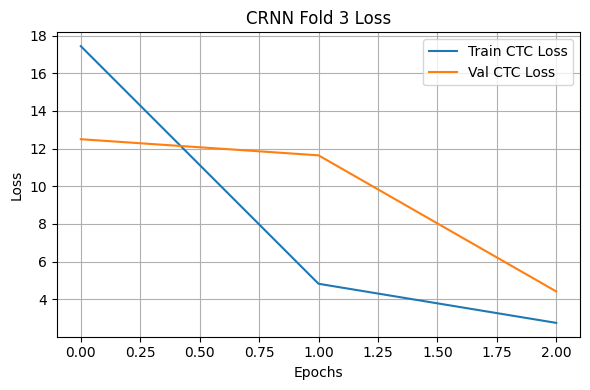


📁 Fold 4/5


Model: "functional_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 256, 64, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 256, 64, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max1 (MaxPooling2D)                  │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128, 32, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 128, 32, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max2 (MaxPooling2D)                  │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 64, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max3 (MaxPooling2D)                  │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64, 64)              │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm1 (Bidirectional)                │ (None, 64, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (Bidirectional)                │ (None, 64, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 64, 41)              │          21,0

 Total params: 2,412,521 (9.20 MB)

 Trainable params: 2,412,073 (9.20 MB)

 Non-trainable params: 448 (1.75 KB)

timestep_len (cut): 62
Max train_input_len length (train): [[62]
 [62]
 [62]
 ...
 [62]
 [62]
 [62]]
Max label length (train): 22
Max label length (val): 24
Epoch 1/60


E0000 00:00:1750629383.291962      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_129_1/dropout_18_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 20.9944 - val_loss: 33.5967
Epoch 2/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 66s 44ms/step - loss: 4.9426 - val_loss: 8.1978
Epoch 3/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 66s 44ms/step - loss: 2.7593 - val_loss: 2.2022


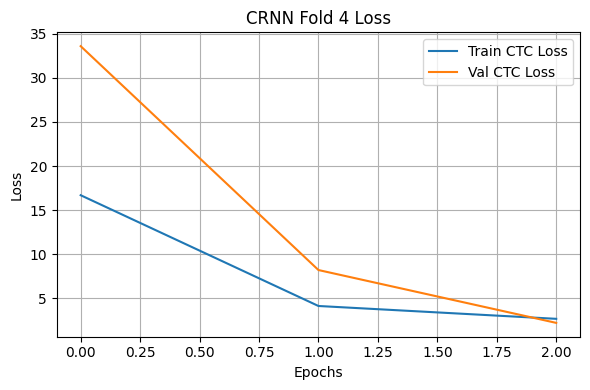


📁 Fold 5/5


Model: "functional_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 256, 64, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 256, 64, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max1 (MaxPooling2D)                  │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128, 32, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 128, 32, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max2 (MaxPooling2D)                  │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 64, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max3 (MaxPooling2D)                  │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64, 64)              │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm1 (Bidirectional)                │ (None, 64, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (Bidirectional)                │ (None, 64, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 64, 41)              │          21,0

 Total params: 2,412,521 (9.20 MB)

 Trainable params: 2,412,073 (9.20 MB)

 Non-trainable params: 448 (1.75 KB)

timestep_len (cut): 62
Max train_input_len length (train): [[62]
 [62]
 [62]
 ...
 [62]
 [62]
 [62]]
Max label length (train): 24
Max label length (val): 20
Epoch 1/60


E0000 00:00:1750629597.951647      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_131_1/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 75s 44ms/step - loss: 20.5141 - val_loss: 28.7263
Epoch 2/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 43ms/step - loss: 4.6254 - val_loss: 3.3530
Epoch 3/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 64s 43ms/step - loss: 2.8220 - val_loss: 2.2710


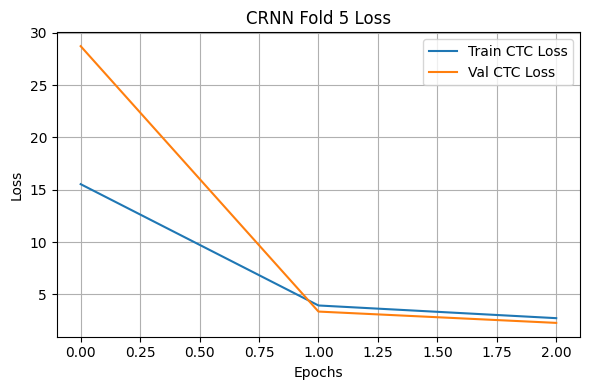

{'CRNN_CTC_Loss': [1.8007062673568726,
  5.977608680725098,
  4.420396327972412,
  2.2021772861480713,
  2.2709951400756836],
 'CNN_Accuracy': [0.6736666560173035,
  0.6728749871253967,
  0.6700000166893005,
  0.6700624823570251,
  0.6734062433242798],
 'LeNet_Accuracy': [0.7118930816650391,
  0.71022629737854,
  0.7054048776626587,
  0.710809588432312,
  0.7107738256454468],
 'VGG_Accuracy': [0.6543750166893005,
  0.6524583101272583,
  0.6519583463668823,
  0.652302086353302,
  0.6564687490463257]}

In [57]:
from sklearn.model_selection import KFold

input_shape = (256, 64, 1)  # giriş kısmı (bence en önemli kısım)
batch_size = 32 #Her seferde eğitime girecek miktar. daha sonra 16'e karar verildi

print(train_x.shape) # Art arda modeller çalışacağı için son kontrol
run_all_models(
    X=train_x,
    y=train_y,  # CRNN için -1, diğerleri categorical
    max_timesteps=62, #-2 yaparak gönderdim direkt 
    max_str_len=max_str_len,
    num_classes=len(alphabets),
    input_shape=input_shape,
    epochs=50, # Eğitim turu 30000 (train_x)/16 (batch_size)* epochs(burada 50)  
        #sabit 50 yazsamda bu değeri modele göre değiştirdim, early_stopping(açıklanacak)
    
    batch_size=16, #her turda alınacak veri miktarı ()
    k=5 #fold sayısı
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

def decode_crnn_predictions(preds, label_map):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    decoded = K.ctc_decode(preds, input_length=input_len, greedy=True)[0][0]
    decoded = K.get_value(decoded)
    return [''.join([label_map[c] for c in seq if c != -1]) for seq in decoded]

def decode_cnn_predictions(preds, label_map):
    pred_classes = np.argmax(preds, axis=-1)  # shape: (batch_size, sequence_length) veya (batch_size,)
    pred_texts = []

    for pred_seq in pred_classes:
        if np.isscalar(pred_seq):  # Eğer sadece bir karakterlik çıktıysa (tek sayı)
            pred_seq = [pred_seq]

        pred_str = ''.join([label_map.get(c, '') for c in pred_seq if c != 0])
        pred_texts.append(pred_str)

    return pred_texts


def visualize_predictions(models_info, X_test, y_test, label_map, num_samples=6):
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    X_sample = X_test[indices]
    y_sample = y_test[indices]

    plt.figure(figsize=(20, 5 * len(models_info)))
    for model_idx, (name, model_path, model_type) in enumerate(models_info):
        model = load_model(model_path, custom_objects={'ctc_lambda_func': lambda y_true, y_pred: y_pred}, safe_mode=False)


        if model_type == 'crnn':
            input_data = model.inputs[0]
            y_pred = model.get_layer("softmax").output
            prediction_model = Model(inputs=input_data, outputs=y_pred)
            preds = prediction_model.predict(X_sample)
            pred_texts = decode_crnn_predictions(preds, label_map)
        else:
            preds = model.predict(X_sample)
            pred_texts = decode_cnn_predictions(preds, label_map)

        for i in range(num_samples):
            plt.subplot(len(models_info), num_samples, model_idx * num_samples + i + 1)

            # Görseli döndürme işlemi
            img = X_sample[i].squeeze()
            img = np.rot90(img, k=-1)  # Saat yönünün tersine 90 derece döndür
            img = np.fliplr(img)  # Yatayda ayna görüntüsü al
            
            plt.imshow(X_sample[i].squeeze(), cmap='gray')
            true_label = ''.join([label_map[c] for c in y_sample[i] if c != -1])
            plt.title(f"{name}\nGerçek Değer: {true_label}\nTahmin: {pred_texts[i]}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')
print("Number of NaNs in train set      : ", test['IDENTITY'].isnull().sum())


test.dropna(axis=0, inplace=True)
test.reset_index(inplace = True, drop=True)

unreadable = test[test['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)
test = test[test['IDENTITY'] != 'UNREADABLE']

test['IDENTITY'] = test['IDENTITY'].str.upper()
test.reset_index(inplace = True, drop=True)

print(test)

test_size=5000


In [ ]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_label_len[i] = len(test.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test.loc[i, 'IDENTITY'])]= label_to_num(test.loc[i, 'IDENTITY']) 

In [ ]:
test_x = []

for i in range(test_size):
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

test_x = np.array(test_x).reshape(-1, 256, 64, 1)

In [ ]:
models_info = [
    ("CRNN fold1", "/kaggle/working/1-5-CRNN.keras", "crnn"),
    ("CRNN fold2", "/kaggle/working/2-5-CRNN.keras", "crnn"),
    ("CRNN fold3", "/kaggle/working/3-5-CRNN.keras", "crnn"),
    ("CRNN fold4", "/kaggle/working/4-5-CRNN.keras", "crnn"),
    ("CRNN fold5", "/kaggle/working/5-5-CRNN.keras", "crnn"),
]

label_map = {i: c for i, c in enumerate(alphabets)}
label_map[len(alphabets)] = ''  # CTC boş karakteri

visualize_predictions(models_info, test_x, test_y, label_map, num_samples=6)


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def decode_predictions(preds, label_map):
    pred_texts = []
    for pred in preds:
        # Eğer pred 2D ise (zaman serisi), axis=-1 üzerinden argmax al
        if len(pred.shape) > 1:
            pred_indices = np.argmax(pred, axis=-1)
        else:
            pred_indices = [np.argmax(pred)]

        pred_str = ''.join([label_map.get(int(c), '') for c in pred_indices if int(c) != 0])
        pred_texts.append(pred_str)
    return pred_texts


def evaluate_model(model_path, X_test, y_test, label_map, decode_fn, model_type='cnn'):
    from tensorflow.keras.models import Model
    import traceback

    print(f"\n🔍 Evaluating model: {model_path} (type: {model_type})")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    try:
        if model_type == 'crnn':
            model = load_model(model_path, custom_objects={'ctc_lambda_func': ctc_lambda_func})
            y_pred_layer = model.get_layer('softmax')
            model = Model(inputs=model.input[0], outputs=y_pred_layer.output)
        else:
            model = load_model(model_path)

        preds = model.predict(X_test)
        print("✅ preds.shape:", preds.shape)

        if model_type == 'crnn':
            y_pred = decode_fn(preds, label_map)
            if isinstance(y_test[0], str):
                y_true = y_test
            else:
                y_true = decode_fn(y_test, label_map)

            correct = sum([p == t for p, t in zip(y_pred, y_true)])
            acc = correct / len(y_true)

        else:
            if y_test.ndim > 1:
                y_true_labels = np.argmax(y_test, axis=-1)
            else:
                y_true_labels = y_test

            if preds.ndim > 1:
                y_pred_labels = np.argmax(preds, axis=-1)
            else:
                y_pred_labels = preds

            acc = accuracy_score(y_true_labels, y_pred_labels)

        return {
            'model': model_path,
            'accuracy': acc,
        }

    except Exception as e:
        print("❌ Error while evaluating:", model_path)
        traceback.print_exc()
        return {
            'model': model_path,
            'accuracy': None,
            'error': str(e)
        }


def compare_models(model_paths, X_test, y_test, label_map, decode_fn_map):
    results = []
    for path in model_paths:
        model_type = 'crnn' if 'crnn' in path else 'cnn'  # basit kontrol
        decode_fn = decode_fn_map.get(model_type, lambda x, y: x)
        result = evaluate_model(path, X_test, y_test, label_map, decode_fn, model_type)
        results.append(result)
    
    df = pd.DataFrame(results)
    print("\n📊 Results:")
    print(df)
    return df


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from sklearn.metrics import accuracy_score

# --- 1) CTC Lambda fonksiyonu ---
from keras.saving import register_keras_serializable

@register_keras_serializable()
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# --- 2) Model yükleme fonksiyonu ---
def load_model_safe(path, model_type):
    if model_type == 'crnn':
        # CRNN modeli yüklerken ctc_lambda_func'u belirt
        train_model = load_model(path, custom_objects={'ctc_lambda_func': ctc_lambda_func}, compile=False)

        input_img = train_model.inputs[0]  # input shape (ör: (256,64,1))
        output = train_model.get_layer(name='softmax').output

        predict_model = keras.models.Model(inputs=input_img, outputs=output)
        return predict_model
    else:
        return load_model(path, compile=False)

# --- 3) Tahminleri decode et ---
def decode_predictions(preds, label_map):
    pred_indices = np.argmax(preds, axis=-1)
    decoded = []
    for seq in pred_indices:
        # -1 padding yok ama yine kontrol ekleyelim
        text = ''.join([label_map[i] for i in seq if i in label_map and label_map[i] != ''])
        decoded.append(text)
    return decoded

# --- 4) Gerçek etiketleri stringe çevir ---
def y_to_strings(y_test, label_map):
    strings = []
    for seq in y_test:
        # -1 padding değerlerini at
        text = ''.join([label_map.get(int(i), '') for i in seq if i != -1 and label_map.get(int(i), '') != ''])
        strings.append(text)
    return strings

# --- 5) Karakter bazında basit accuracy ---
def simple_char_accuracy(y_true, y_pred):
    total_chars = 0
    correct_chars = 0
    for true_seq, pred_seq in zip(y_true, y_pred):
        min_len = min(len(true_seq), len(pred_seq))
        correct_chars += sum(t == p for t, p in zip(true_seq[:min_len], pred_seq[:min_len]))
        total_chars += max(len(true_seq), len(pred_seq))
    return correct_chars / total_chars if total_chars > 0 else 0

# --- 6) Accuracy hesaplama ---
def calculate_accuracy(preds, y_test_raw, label_map, model_type):
    if model_type == 'crnn':
        decoded_preds = decode_predictions(preds, label_map)
        y_true_strings = y_to_strings(y_test_raw, label_map)
        acc = simple_char_accuracy(y_true_strings, decoded_preds)
        return acc
    else:
        # CNN, LeNet, VGG vs. için:
        # Eğer y_test_raw 2D ise ve padding varsa, -1'leri temizle, ve ilk karakter alınabilir
        # Model tek karakter sınıflandırıyorsa:
        y_true_raw_1d = []
        for seq in y_test_raw:
            # Padding -1 değerlerini çıkar, ilk gerçek karaktere bak:
            filtered = [int(i) for i in seq if i != -1]
            if len(filtered) == 0:
                y_true_raw_1d.append(-1)  # ya da uygun boş sınıf
            else:
                y_true_raw_1d.append(filtered[0])
        y_true_raw_1d = np.array(y_true_raw_1d)

        pred_classes = np.argmax(preds, axis=1)

        # Aynı uzunlukta olmalı:
        min_len = min(len(y_true_raw_1d), len(pred_classes))
        y_true_raw_1d = y_true_raw_1d[:min_len]
        pred_classes = pred_classes[:min_len]

        # Padding olanları çıkar (örneğin -1 etiketli)
        valid_idx = y_true_raw_1d != -1
        y_true_valid = y_true_raw_1d[valid_idx]
        pred_valid = pred_classes[valid_idx]

        return accuracy_score(y_true_valid, pred_valid)

# --- 7) Modelleri karşılaştır ---
def compare_models(model_paths, X_test, y_test_raw, label_map, model_types):
    results = []
    for path, model_type in zip(model_paths, model_types):
        try:
            print(f"Loading {path} ({model_type})")
            model = load_model_safe(path, model_type)
            model.save("crnnFold4.keras")
            preds = model.predict(X_test)
            accuracy = calculate_accuracy(preds, y_test_raw, label_map, model_type)
            results.append({'model': path.split('/')[-2] + '/' + path.split('/')[-1], 'accuracy': accuracy, 'error': None})
        except Exception as e:
            results.append({'model': path.split('/')[-2] + '/' + path.split('/')[-1], 'accuracy': None, 'error': str(e)})

    df = pd.DataFrame(results)
    print(df)

    # Grafik çizimi
    plt.figure(figsize=(10,6))
    plt.bar(df['model'], df['accuracy'], color='skyblue')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0,1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.show()

    return df




In [ ]:
# --- 8) Örnek kullanım ---
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-' '"
label_map = {i: c for i, c in enumerate(alphabets)}
label_map[len(alphabets)] = ''  # boş karakter

model_paths = [
    '/kaggle/working/1-5-CRNN.keras',
    '/kaggle/working/2-5-CRNN.keras',
    '/kaggle/working/3-5-CRNN.keras',
    '/kaggle/working/4-5-CRNN.keras',
    '/kaggle/working/5-5-CRNN.keras'
]
model_types = ['crnn', 'crnn', 'crnn', 'crnn','crnn']

# test_x, test_y tanımlı ve uygun formatta olmalı
# örn: test_y shape (num_samples, max_label_len), değerler integer ve padding -1 ile

results_df = compare_models(model_paths, test_x, test_y, label_map, model_types)


In [ ]:
predModel=load_model_safe('/kaggle/working/4-5-CRNN.keras','crnn')
predModel.save('CRNNFold4Model.keras')
predModel.save('CRNNFold4Model.h5')